**Note:** This notebook assumes that you have already computed an *inverted index*. If you have not done so, please follow the [vector-search-comparison notebook](vector-search-comparison.ipynb) first, to create one.

In [3]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.curdir, "..")))

In [ ]:
from collections import defaultdict
import math
import pickle
from typing import Dict, List, Tuple
from elastic.vectorizer import TFIDFVectorizer
from elasticsearch import Elasticsearch
import os


class QueryTermsFirstSearch:
    def __init__(
        self,
        client: Elasticsearch,
        index_name: str,
        analyzer_name: str,
        inverted_index: Dict[str, List[Tuple[int, float]]],
        doc_ids: List[str],
        vector_norms: List[float],
    ):
        self.client = client
        self.index_name = index_name
        self.analyzer_name = analyzer_name
        self.vectorizer = TFIDFVectorizer(client, index_name=index_name, analyzer_name=analyzer_name)
        self.inverted_index = inverted_index
        self.doc_ids = doc_ids
        self.vector_norms = vector_norms

    @classmethod
    def from_disk(
        cls,
        client: Elasticsearch,
        index_name: str,
        analyzer_name: str,
        cache_dir: os.PathLike,
    ) -> "QueryTermsFirstSearch":
        """
        Load a QueryTermsFirstSearch instance from disk.

        Args:
            client (Elasticsearch): The Elasticsearch client.
            index_name (str): The name of the Elasticsearch index.
            analyzer_name (str): The name of the analyzer used.
            cache_dir (os.PathLike): The directory where the inverted index, document IDs, and vector norms are stored.

        Returns:
            QueryTermsFirstSearch: An instance of QueryTermsFirstSearch.
        """
        if not os.path.exists(cache_dir):
            raise ValueError(f"Cache directory {cache_dir} does not exist")
        if not os.path.isdir(cache_dir):
            raise ValueError(f"Cache directory {cache_dir} is not a directory")

        inverted_index_path = os.path.join(cache_dir, "inverted_index.pkl")
        doc_ids_path = os.path.join(cache_dir, "doc_ids.pkl")
        vector_norms_path = os.path.join(cache_dir, "vector_norms.pkl")

        if not os.path.exists(inverted_index_path):
            raise ValueError(f"Inverted index file {inverted_index_path} does not exist")
        if not os.path.exists(doc_ids_path):
            raise ValueError(f"Document IDs file {doc_ids_path} does not exist")
        if not os.path.exists(vector_norms_path):
            raise ValueError(f"Vector norms file {vector_norms_path} does not exist")

        with open(inverted_index_path, "rb") as f:
            inverted_index = pickle.load(f)
        with open(doc_ids_path, "rb") as f:
            doc_ids = pickle.load(f)
        with open(vector_norms_path, "rb") as f:
            vector_norms = pickle.load(f)
        return cls(client, index_name, analyzer_name, inverted_index, doc_ids, vector_norms)

    def search(self, query_string: str, r: int = 10) -> List[Tuple[str, float]]:
        """
        Search for the top r documents matching the query string.

        Args:
            query_string (str): The query string to search for.
            r (int): The number of top documents to return.

        Returns:
            List[Tuple[str, float]]: A list of tuples containing document IDs and their similarity scores.
        """
        query_vector = self.vectorizer.tf_idf_text(query_string)
        query_norm = math.sqrt(sum(weight**2 for weight in query_vector.values()))
        query_vector_normalized = {token: weight / query_norm for token, weight in query_vector.items()}

        similarities = defaultdict(float)
        for term, weight in query_vector_normalized.items():
            if term in self.inverted_index:
                for doc_index, doc_weight in self.inverted_index[term]:
                    similarities[doc_index] += weight * doc_weight

        for doc_index in similarities:
            similarities[doc_index] /= self.vector_norms[doc_index]

        sorted_answer = sorted(similarities.items(), key=lambda kv: kv[1], reverse=True)
        results = [(self.doc_ids[doc_index], score) for doc_index, score in sorted_answer[:r]]
        return results

In [6]:
client = Elasticsearch("http://localhost:9200", request_timeout=1000)
index_name = "arxiv"
analyzer_name = "custom"
searcher = QueryTermsFirstSearch.from_disk(
    client,
    index_name,
    analyzer_name,
    cache_dir="../data/cache",
)

In [ ]:
# Construct a list of several queries to test. We'll do so by combining several common terms.
common_terms = [
    "machine",
    "learning",
    "neural",
    "network",
    "deep",
    "data",
    "model",
    "analysis",
    "algorithm",
    "performance",
]
import random

random.seed(42)
n_test_queries = 100
max_query_length = 3
test_queries = []
for _ in range(n_test_queries):
    query = " ".join(random.sample(common_terms, random.randint(1, max_query_length)))
    test_queries.append(query)

for query in test_queries:
    print(f"Query: {query}")

Query: learning machine deep
Query: network
Query: learning
Query: algorithm learning model
Query: machine
Query: network
Query: algorithm
Query: machine algorithm network
Query: algorithm model network
Query: performance deep
Query: neural
Query: model data deep
Query: network
Query: learning performance
Query: learning data
Query: performance deep
Query: analysis
Query: learning model performance
Query: deep data network
Query: learning machine network
Query: learning network
Query: model
Query: analysis data
Query: data
Query: network deep
Query: learning neural network
Query: analysis
Query: deep algorithm
Query: data
Query: network
Query: data
Query: deep learning
Query: performance
Query: data network analysis
Query: analysis neural
Query: neural network
Query: algorithm performance deep
Query: performance model algorithm
Query: network neural
Query: analysis learning machine
Query: neural
Query: neural model learning
Query: model analysis
Query: deep algorithm machine
Query: lea

In [ ]:
import time
import pandas as pd

# (query, fast_time, es_time)
search_times: List[Tuple[str, float, float]] = []

n_query_repeats = 5
r = 10
for query in test_queries:
    for _ in range(n_query_repeats):
        start_time = time.time()
        results = searcher.search(query, r=r)
        fast_search_time = time.time() - start_time

        start_time = time.time()
        results = client.search(index=index_name, body={"query": {"match": {"text": query}}, "size": r})
        es_search_time = time.time() - start_time
        search_times.append((query, fast_search_time, es_search_time))

df = pd.DataFrame(search_times, columns=["query", "fast-search", "elasticsearch"])

In [39]:
print("Fast Search Average Time:", df["fast-search"].mean())
print("Elasticsearch Average Time:", df["elasticsearch"].mean())

Fast Search Average Time: 0.05047674179077148
Elasticsearch Average Time: 0.0475879955291748


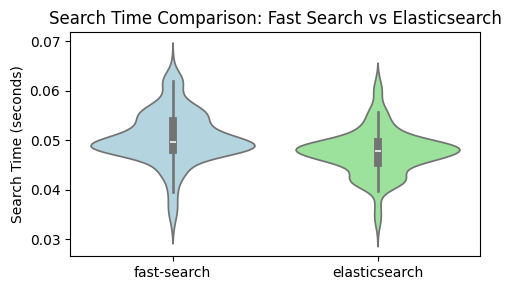

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("../images", exist_ok=True)


plt.figure(figsize=(5, 3))
sns.violinplot(data=[df["fast-search"], df["elasticsearch"]], palette=["lightblue", "lightgreen"])
plt.ylabel("Search Time (seconds)")
plt.title("Search Time Comparison: Fast Search vs Elasticsearch")
plt.tight_layout()
plt.savefig("../images/fast-vs-elasticsearch-times.png")
plt.show()